In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')
from src.utils import preprocess_cscid
from src.data import read_data, setup_paths
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# read full data
paths = setup_paths()
df_full = pd.read_parquet(os.path.join(paths['out_data'], 'nway_csc21_gaia3_full.parquet'))

# get basic matches (positives and negatives)
separation_threshold = 1.3 
range_offaxis = '0-3'

# get positive cases (highest p_i per source) 
df_pos = df_full.loc[df_full.groupby('csc21_name')['p_i'].idxmax()]
df_pos = df_pos[df_pos['separation'] <= separation_threshold]

# get negative cases (lowest p_i per source)
df_pos_comp = df_full[~df_full.index.isin(df_pos.index)]
df_neg = df_pos_comp.loc[df_pos_comp.groupby('csc21_name')['p_i'].idxmin()]

# split chandra ids into train/val splits
cscids = df_pos.csc21_name.unique()
cscids_train, cscids_val = train_test_split(cscids, test_size=0.2, random_state=42)

df_analysis = pd.concat([df_pos, df_neg])

# create train/val sets
train_set = df_analysis[df_analysis['csc21_name'].isin(cscids_train)]
val_set = df_analysis[df_analysis['csc21_name'].isin(cscids_val)]

# check overlaps
chandra_train = set(train_set['csc21_name'])
chandra_val = set(val_set['csc21_name'])
gaia_train = set(train_set['gaia3_source_id'])
gaia_val = set(val_set['gaia3_source_id'])

print(f"Chandra overlap: {len(chandra_train & chandra_val)}")
print(f"Gaia overlap: {len(gaia_train & gaia_val)}")
print(f"Gaia percentage: {len(gaia_train & gaia_val)/len(gaia_train | gaia_val)}")

Chandra overlap: 0
Gaia overlap: 2854
Gaia percentage: 0.016097373883223534


In [4]:
parquetfull = pd.read_parquet('../data/nway_CSC21_GAIA3.parquet')


In [13]:
parquetfull.columns


Index(['ENS', 'CSC21_CSCID', 'CSC21_RA', 'CSC21_Dec', 'CSC21_Errmaj',
       'CSC21_Errmin', 'CSC21_ErrPA', 'GAIA3_source_id', 'GAIA3_ra',
       'GAIA3_dec', 'GAIA3_era', 'GAIA3_edec', 'GAIA3_epa',
       'GAIA3_phot_g_mean_mag', 'GAIA3_phot_bp_mean_mag',
       'GAIA3_phot_rp_mean_mag', 'GAIA3_bp_rp', 'GAIA3_bp_g', 'GAIA3_g_rp',
       'GAIA3_parallax', 'GAIA3_parallax_over_error', 'GAIA3_pmra',
       'GAIA3_pmdec', 'Separation_GAIA3_CSC21', 'Separation_GAIA3_CSC21_ra',
       'Separation_GAIA3_CSC21_dec', 'Separation_max', 'ncat',
       'dist_bayesfactor', 'dist_post', 'p_single', 'p_any', 'p_i',
       'match_flag', 'EPOS1', 'EPOS2', 'EPOS', 'SEP_EPOS'],
      dtype='object')

In [16]:
parquetfull.iloc[:, 20:][['Separation_GAIA3_CSC21', 'EPOS1', 'EPOS2', 'SEP_EPOS']]

,Separation_GAIA3_CSC21,EPOS1,EPOS2,SEP_EPOS
0,8.700034,0.204903,0.000293,42.459329
1,8.647368,0.204903,0.000296,42.202300
2,0.499088,0.204903,0.000016,2.435736
3,12.379020,0.204903,0.002944,60.407944
4,0.130304,0.118465,0.002207,1.099742
...,...,...,...,...
2402335,4.277875,1.870930,0.000376,2.286497
2402336,12.876800,1.870930,0.000200,6.882566
2402337,14.585110,1.870930,0.000169,7.795647
2402338,12.042810,1.870930,0.002001,6.436801


In [7]:
# identify most probable matches (positives)
df_pos = df_full.loc[df_full.groupby('csc21_name')['p_i'].idxmax()]

# identify least probable matches (negatives)
df_pos_comp = df_full[~df_full.index.isin(df_pos.index)]

df_neg = df_pos_comp.loc[df_pos_comp.groupby('csc21_name')['separation'].idxmax()]
#df_neg = df_neg.query('separation >= 5')

# label positives by off-axis angle
df_pos['threshold_label'] = pd.cut(
    df_pos['min_theta_mean'],
    bins=[0, 3, 6, float('inf')],
    labels=['0-3', '3-6', '6+']
)



In [8]:
# filter for specific range and separation threshold
pos_range = df_pos.query(f'threshold_label == "0-3" and separation <= 1.3 and p_any >= 0.9')
chandra_ids_in_pos = pos_range['csc21_name'].unique()
neg_range = df_neg[df_neg['csc21_name'].isin(chandra_ids_in_pos)]

In [22]:
# positives based on p_i min(p_i)
#df_pos_pi = df_full.loc[df_full.groupby('csc21_name')['p_i'].idxmax()]

# negatives based on separation
#df_neg_sep = df_full.loc[df_full.groupby('csc21_name')['separation'].idxmax()]

gaia_ids_neg_sep = neg_range['gaia3_source_id']
gaia_idspospi = pos_range['gaia3_source_id']

common_gaia_ids = set(gaia_idspospi) & set(gaia_ids_neg_sep) 

print(f"Number of common Gaia IDs: {len(common_gaia_ids)}")

Number of common Gaia IDs: 2824


In [27]:
len(set(gaia_idspospi) & set(gaia_ids_neg_sep))

2824

In [25]:
len(set(gaia_idspospi) |  set(gaia_ids_neg_sep)) 

49504

In [26]:
len(set(gaia_idspospi) & set(gaia_ids_neg_sep)) / len(set(gaia_idspospi) |  set(gaia_ids_neg_sep)) 

0.0570458952811894

In [5]:
len(chandra_ids_in_pos)

30279

In [33]:
31747/len(set(gaia_idspospi) | set(gaia_ids_neg_sep))

0.08269989215435994

In [18]:
len(common_gaia_ids)/len(set(gaia_train))

0.2217511263227744

Chandra overlap: 0
Gaia overlap: 2854
Gaia percentage: 0.016097373883223534


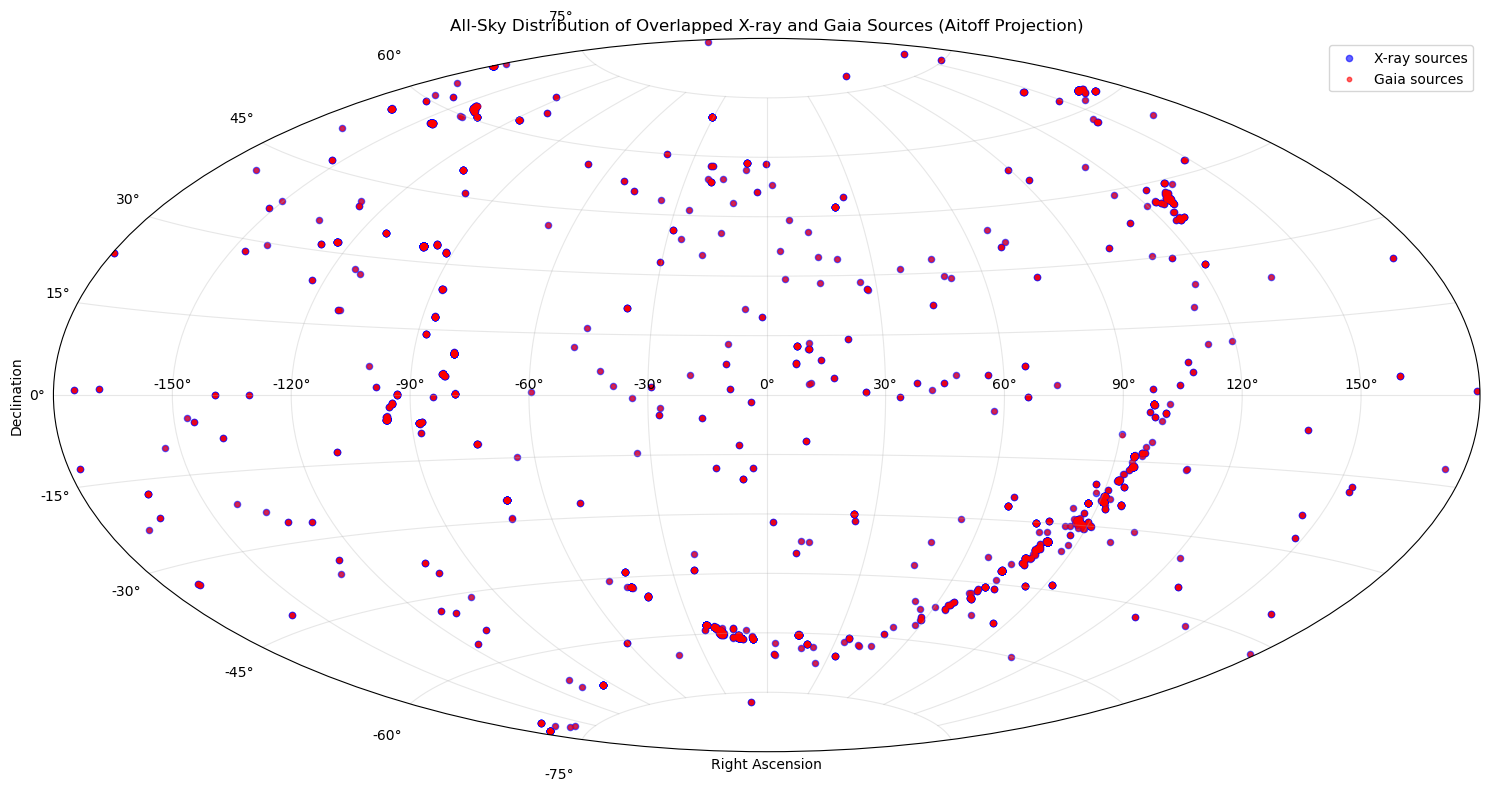

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure with Aitoff projection
plt.figure(figsize=(15, 10))
ax = plt.subplot(111, projection='aitoff')
# check overlaps
chandra_train = set(train_set['csc21_name'])
chandra_val = set(val_set['csc21_name'])
gaia_train = set(train_set['gaia3_source_id'])
gaia_val = set(val_set['gaia3_source_id'])

print(f"Chandra overlap: {len(chandra_train & chandra_val)}")
print(f"Gaia overlap: {len(gaia_train & gaia_val)}")
print(f"Gaia percentage: {len(gaia_train & gaia_val)/len(gaia_train | gaia_val)}")

# Find common sources
common_sources = gaia_train & gaia_val

# Filter the train_set for common sources
common_train_set = train_set[train_set['gaia3_source_id'].isin(common_sources)]

# Convert coordinates to radians and plot
# X-ray sources (blue)
ra_xray = np.radians(common_train_set['csc21_ra'] - 180)  # shift RA values
dec_xray = np.radians(common_train_set['csc21_dec'])
ax.scatter(ra_xray, dec_xray, c='blue', alpha=0.6, s=20, label='X-ray sources')

# Gaia sources (red)
ra_gaia = np.radians(common_train_set['gaia3_ra'] - 180)  # shift RA values
dec_gaia = np.radians(common_train_set['gaia3_dec'])
ax.scatter(ra_gaia, dec_gaia, c='red', alpha=0.6, s=10, label='Gaia sources')

# Customize plot
ax.grid(True, alpha=0.3)
plt.title('All-Sky Distribution of Overlapped X-ray and Gaia Sources (Aitoff Projection)')
plt.legend(loc='upper right')

# Set axis labels
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.tight_layout()
plt.show()